In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# Training Dataset

In [3]:
image_size = (128, 128)
batch_size = 4

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/gender-recognition-200k-images-celeba/Dataset/Train",
    seed=2022,
    class_names=["Female", "Male"],
    image_size=image_size,
    batch_size=batch_size,
)

Found 160000 files belonging to 2 classes.


2022-04-16 14:30:34.208163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 14:30:34.299502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 14:30:34.300423: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-16 14:30:34.302822: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Test Dataset

In [4]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/gender-recognition-200k-images-celeba/Dataset/Test",
    seed=2022,
    class_names=["Female", "Male"],
    image_size=image_size,
    batch_size=batch_size,
)

Found 20001 files belonging to 2 classes.


# Validation Dataset

In [5]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/gender-recognition-200k-images-celeba/Dataset/Validation",
    seed=2022,
    class_names=["Female", "Male"],
    image_size=image_size,
    batch_size=batch_size,
)

Found 22598 files belonging to 2 classes.


2022-04-16 14:31:24.333832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


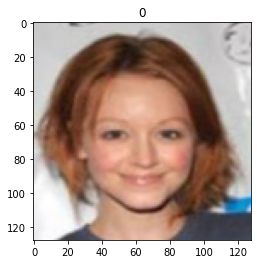

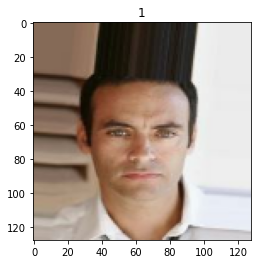

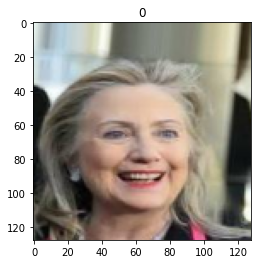

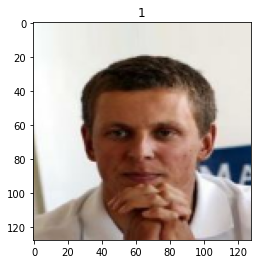

In [6]:
for img, lbl in train_ds.take(1):
    for i, l in zip(img, lbl):
        plt.imshow(i.numpy().astype("uint8"))
        plt.title(str(l.numpy()))
        plt.show()
    break

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Activation
from tensorflow.keras.layers import concatenate, Rescaling
from tensorflow.keras.optimizers import Adam

In [8]:
def resblock(input_layer, filters):
    initial_layer = MaxPool2D(2)(input_layer)
    forward = Conv2D(filters, (3, 3), padding="same") (input_layer)
    forward = MaxPool2D(2)(forward)
    output_layer = concatenate([initial_layer, forward])
    return output_layer

def create_model(input_size, output_classes):
    input_layer = Input(shape=(input_size))
    forward = Rescaling(1.0 / 255)(input_layer)
    filters = 32
    
    forward = Conv2D(filters, (3, 3), padding="same", activation="relu") (forward)
    forward = MaxPool2D(2)(forward)
    
    for _ in range(4):
        forward = resblock(forward, filters)
        filters *= 2
    
    forward = Flatten()(forward)
    forward = Dense(output_classes, activation="sigmoid")(forward)
    model = Model(input_layer, forward)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["acc"])
    return model

In [9]:
model = create_model(input_size=(128, 128, 3), output_classes=1)

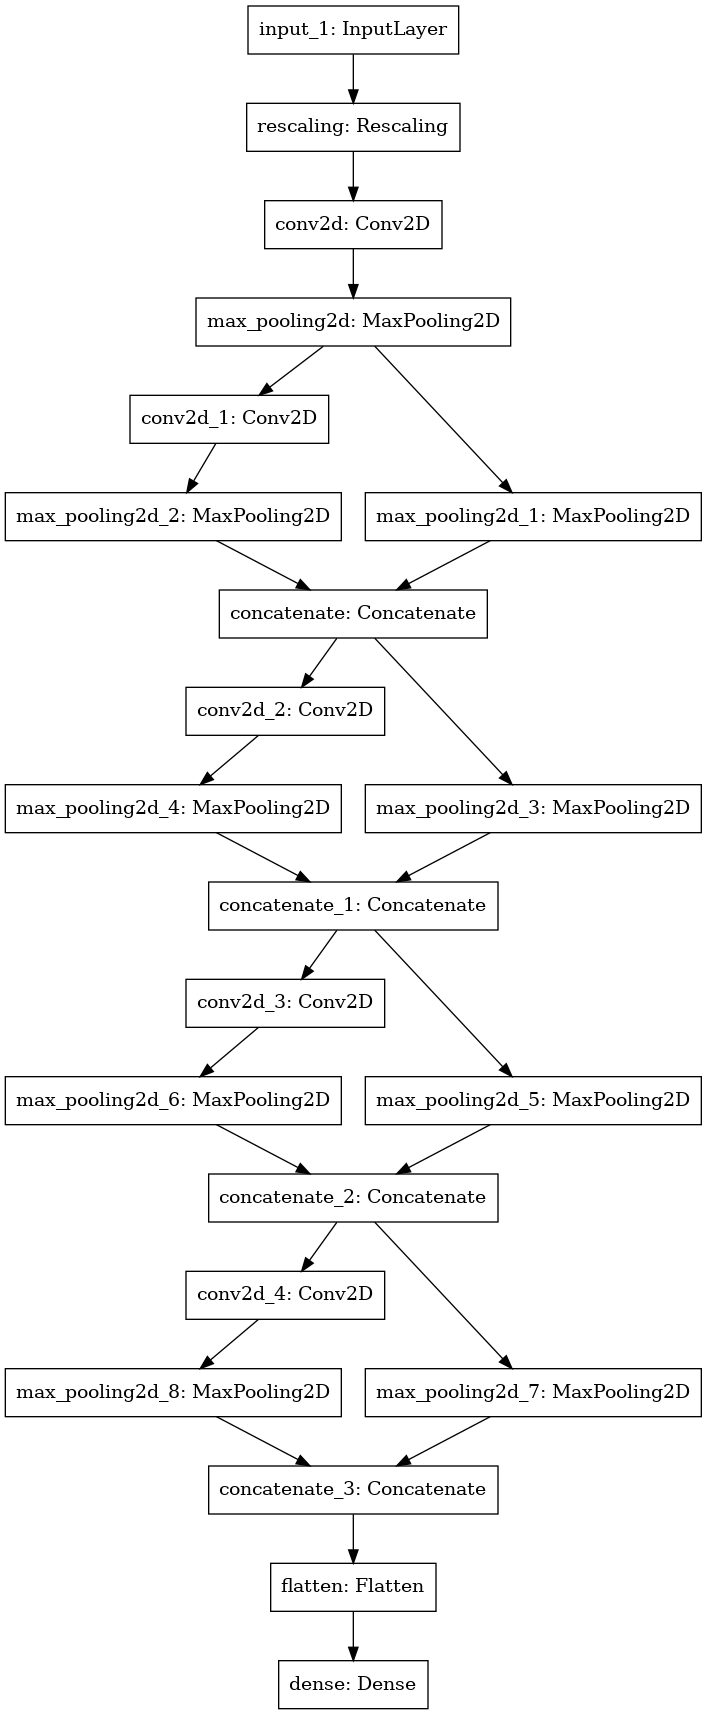

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [11]:
model.fit(train_ds, validation_data=valid_ds, epochs=30, shuffle=True)

Epoch 1/30


2022-04-16 14:31:28.219401: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40000/40000 [==============================] - 551s 14ms/step - loss: 0.1110 - acc: 0.9563 - val_loss: 0.0699 - val_acc: 0.9723
Epoch 2/30
40000/40000 [==============================] - 327s 8ms/step - loss: 0.0612 - acc: 0.9782 - val_loss: 0.0681 - val_acc: 0.9759
Epoch 3/30
40000/40000 [==============================] - 332s 8ms/step - loss: 0.0414 - acc: 0.9857 - val_loss: 0.0752 - val_acc: 0.9764
Epoch 4/30
40000/40000 [==============================] - 334s 8ms/step - loss: 0.0262 - acc: 0.9914 - val_loss: 0.1048 - val_acc: 0.9726
Epoch 5/30
40000/40000 [==============================] - 324s 8ms/step - loss: 0.0183 - acc: 0.9937 - val_loss: 0.1079 - val_acc: 0.9745
Epoch 6/30
40000/40000 [==============================] - 328s 8ms/step - loss: 0.0153 - acc: 0.9945 - val_loss: 0.1133 - val_acc: 0.9766
Epoch 7/30
40000/40000 [==============================] - 331s 8ms/step - loss: 0.0143 - acc: 0.9948 - val_loss: 0.1287 - val_acc: 0.9758
Epoch 8/30
40000/40000 [====================

In [12]:
classes = {0: "Female",
          1: "Male"}

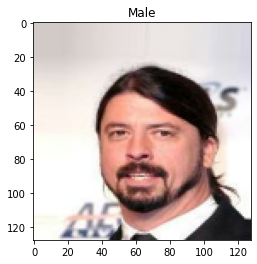

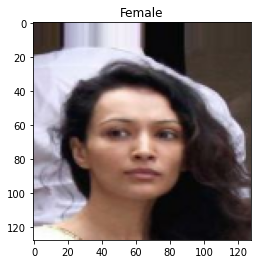

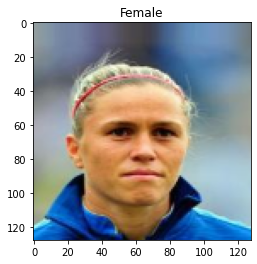

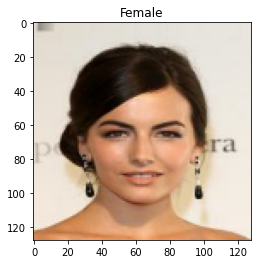

In [13]:
for images, labels in test_ds.take(1):
    pred = model.predict(images)
    for i, r, p in zip(images, labels, pred):
        p = np.round(p[0])
        plt.imshow(i.numpy().astype("uint8"))
        plt.title(classes[p])
        plt.show()
    break